# Using Covalent for Ensemble Classification

In this tutorial, we show how a quantum circuit can be initialized with two different sets of pre-trained parameters and used to create an ensemble model with Covalent and Pennylane to solve machine learning classification problem.

With each set of pre-trained parameters, we make independant predictions and an ensemble model is formed by choosing the prediction of the most confident set of parameters. We create a Covalent workflow that runs each initialization of the QPU device in parallel and processes the results to find the ensemble prediction. We also keep track of the individual predictions from each circuit.

This demo is based on the Pennylane tutorial [**Ensemble classification with Forest and Qiskit devices**](https://pennylane.ai/qml/demos/ensemble_multi_qpu.html).

We start by installing and importing all the necessary packages. In order to execute this notebook, the user might need to set `ulimit -n 10240` in the terminal.

In [1]:
# Install necessary packages
!pip install -r ./assets/requirements.txt

In [2]:
from collections import Counter


import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import sklearn.datasets
import sklearn.decomposition
import torch
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from covalent.executor import DaskExecutor
from dask.distributed import LocalCluster

import covalent as ct


In [3]:
cluster = LocalCluster()
dask = ct.executor.DaskExecutor(scheduler_address=cluster.scheduler_address)


/Users/faiyaz/opt/anaconda3/envs/new/lib/python3.8/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54494 instead
  warnings.warn(


# Load, preprocess and split data

We use the Iris dataset in this tutorial. We do some necessary preprocessing on the data and split them into a training and test dataset.

### Iris dataset

The Iris dataset is very well known in machine learning, and used for pattern recognition and classification. It consists of samples belonging to 3 classes: Iris Setosa, Iris Versicolour and Iris Virginica. Each sample has four features related to the length and width of the sepal and petal.

For the sake of simplicity of the model, we compress the number of features in the dataset into 2 using Principal Component Analysis (PCA). We will be using a pre-trained model and the PyTorch interface and we’ll see that ensembling allows each set of parameters to specialize towards different classes.

In [4]:
n_features = 2
n_classes = 3
n_samples = 150

data = sklearn.datasets.load_iris()
x = data["data"]
y = data["target"]


def process_data(x, y):
    np.random.seed(1967)
    indices = np.random.permutation(x.shape[0])
    x = x[indices, :]
    y = y[indices]

    pca = sklearn.decomposition.PCA(n_components=n_features)
    pca.fit(x)
    x = pca.transform(x)

    x_min = np.min(x, axis=0)
    x_max = np.max(x, axis=0)

    x = 2 * np.pi * (x - x_min) / (x_max - x_min) - np.pi

    split = 125

    x_train = x[:split]
    x_test = x[split:]
    y_train = y[:split]
    y_test = y[split:]

    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = process_data(x, y)


# Plot the data

We plot the data to visualize it and to verify that it is seperable with just two features. Note that this is not included in the Covalent workflow but rather for a visual understanding of the compressed dataset.

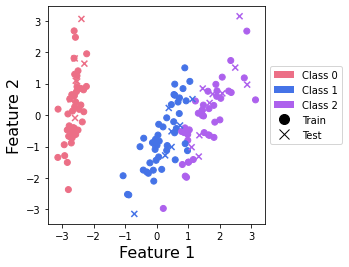

In [5]:
colours = ["#ec6f86", "#4573e7", "#ad61ed"]


def plot_points(x_train, y_train, x_test, y_test):
    c_train = []
    c_test = []

    for y in y_train:
        c_train.append(colours[y])

    for y in y_test:
        c_test.append(colours[y])

    plt.scatter(x_train[:, 0], x_train[:, 1], c=c_train)
    plt.scatter(x_test[:, 0], x_test[:, 1], c=c_test, marker="x")

    plt.xlabel("Feature 1", fontsize=16)
    plt.ylabel("Feature 2", fontsize=16)

    ax = plt.gca()
    ax.set_aspect(1)

    c_transparent = "#00000000"

    custom_lines = [
        Patch(facecolor=colours[0], edgecolor=c_transparent, label="Class 0"),
        Patch(facecolor=colours[1], edgecolor=c_transparent, label="Class 1"),
        Patch(facecolor=colours[2], edgecolor=c_transparent, label="Class 2"),
        Line2D(
            [0],
            [0],
            marker="o",
            color=c_transparent,
            label="Train",
            markerfacecolor="black",
            markersize=10,
        ),
        Line2D(
            [0],
            [0],
            marker="x",
            color=c_transparent,
            label="Test",
            markerfacecolor="black",
            markersize=10,
        ),
    ]

    ax.legend(handles=custom_lines, bbox_to_anchor=(1.0, 0.75))


plot_points(x_train, y_train, x_test, y_test)
plt.show()


This plot shows us that class 0 points can be nicely separated, but that there is an overlap between points from classes 1 and 2.



# Construct the workflow

The workflow is broken down into subtasks (functions with the Covalent electron decorator) as follows.

1. `get_circ` - Construct and return a circuit based on the parameters.
2. `decision` - Choose the class with maximum confidence.
3. `eval_circ` - Evaluate the circuit and return the expected value.
4. `get_results` - Combines the results from multiple executions.
5. `predict_point` - Chooses the output of the QPU parameters which is most confident about its prediction and set it as the prediction of ensemble model.


In [6]:
@ct.electron()
def get_circ(CZ_params, n_wires=4):

    dev = qml.device("default.qubit", wires=n_wires)

    @qml.qnode(dev, interface="torch")
    def circuit(params, x=None):
        for i in range(n_wires):
            qml.RX(x[i % n_features], wires=i)
            qml.Rot(*params[0, i], wires=i)

        qml.CZ(wires=CZ_params[0])
        qml.CZ(wires=CZ_params[1])
        qml.CZ(wires=CZ_params[2])

        for i in range(n_wires):
            qml.Rot(*params[1, i], wires=i)
        return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2))

    return circuit


@ct.electron()
def eval_circ(circuit, params, x):
    return circuit(params, x)


In [7]:
@ct.electron()
def decision(softmax):
    return int(torch.argmax(softmax))


@ct.electron()
def get_results(res0, res1):
    return torch.cat((torch.unsqueeze(res0, 0), torch.unsqueeze(res1, 0)), 0)


@ct.electron()
def predict_point(results):
    softmax = torch.nn.functional.softmax(results, dim=1)
    choice = torch.where(softmax == torch.max(softmax))[0][0]
    chosen_softmax = softmax[choice]
    return decision(chosen_softmax), decision(softmax[0]), decision(softmax[1]), int(choice)


Having constructed the subtasks, we now construct the `predict_workflow` with the Covalent lattice decorator.

In [8]:
@ct.lattice(executor=dask)
def predict_workflow(params, x=None, parallel=True):

    predictions_ensemble = []
    predictions_0 = []
    predictions_1 = []
    choices = []
    for i, x_point in enumerate(x):

        circ_0 = get_circ(CZ_params=[[1, 0], [1, 2], [3, 0]])
        res0 = eval_circ(circ_0, params[0], x_point)

        circ_1 = get_circ(CZ_params=[[0, 1], [1, 2], [1, 3]])
        res1 = eval_circ(circ_1, params[1], x_point)

        result_int = get_results(res0, res1)
        results = predict_point(result_int)

        predictions_ensemble.append(results[0])
        predictions_0.append(results[1])
        predictions_1.append(results[2])
        choices.append(results[3])
    return predictions_ensemble, predictions_0, predictions_1, choices


### Directed Acyclic Graph (DAG)

In order to verify if the workflow construction is properly defined, we can use the draw method in the predict_workflow or check out the DAG in the Covalent UI. The graph contains information on execution status, task definition, runtime, input parameters, and more. 

The Directed Acyclic Graph (DAG) generated for predicting a single sample using the ensemble model is shown below:

![DAG](assets/covalent-ensemble-DAG.png)

# Executing the workflow

Once we have ensured that the workflow has been constructed properly, we can submit it using Covalent `dispatch`. When a workflow has been successfully dispatched, a dispatch ID is generated. This ensures that the Jupyter notebook or script where the task was dispatched can be closed if needed. The Covalent UI server receives updates from the dispatcher server:

We load the pretrained weights and use it to predict the classes using Covalent dispatch.

Later, the execution results are retrieved uusing the Covalent `get_result` method.

In [9]:
params = np.load("assets/params.npy")
dispatch_id_train = ct.dispatch(predict_workflow)(params, x=x_train)
dispatch_id_test = ct.dispatch(predict_workflow)(params, x=x_test)


In [10]:
train_result = ct.get_result(dispatch_id=dispatch_id_train, wait=True)
p_train, p_train_0, p_train_1, choices_train = train_result.result


test_result = ct.get_result(dispatch_id=dispatch_id_test, wait=True)
p_test, p_test_0, p_test_1, choices_test = train_result.result


### Model accuracy

In order to calculate how well the ensemble model performs, we compare the model predictions to the actual classification values. We calculate the accuracy of the training set as well as the test set, and it can be observed that the ensemble model performs better than the individual circuits.

In [ ]:
def accuracy(predictions, actuals):
    count = 0
    print(len(predictions), len(actuals))

    for i in range(len(predictions)):
        if predictions[i] == actuals[i]:
            count += 1

    accuracy = count / (len(predictions))
    return accuracy


print(f"Training accuracy (ensemble): {accuracy(p_train, y_train)}")
print(f"Training accuracy (params0):  {accuracy(p_train_0, y_train)}")
print(f"Training accuracy (params1):  {accuracy(p_train_1, y_train)}")

print("--------------------------------------------------------")

print(f"Test accuracy (ensemble): {accuracy(p_test, y_test)}")
print(f"Test accuracy (params0):  {accuracy(p_test_0, y_test)}")
print(f"Test accuracy (params1):  {accuracy(p_test_1, y_test)}")


# Conclusion

In this tutorial, we created a Covalent workflow to predict the classes of Iris dataset using ensemble model. The ensemble model was designed to choose the most confident predictions from two set of pretrained parameters for a quantum circuit. The key takeaways from this tutorial are:

1)  Covalent helps create workflows that can take advantage of parallel execution of quantum circuits and can organize, track, and dispatch experiments.

2) The ensemble model outperforms both individual parameter models.
